In [1]:
import cv2
import numpy as np
import scipy.stats as stats
import skimage
import imageio
import mpmath
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from scipy.stats import multivariate_normal
from skimage import data, img_as_float
from skimage import exposure
from skimage.filters import threshold_mean
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import sklearn.metrics
from scipy.signal import convolve2d
import sklearn
from sklearn.cluster import KMeans

In [2]:
image_path = '../images/'

In [3]:
# Reading in images and mapping to RGB

image1 = img_as_float(cv2.imread(image_path + 'image-35.jpg')[:,:,::-1])
image2 = img_as_float(cv2.imread(image_path +  'image-83.jpg')[:,:,::-1])
image3 = img_as_float(cv2.imread(image_path +  'image-110.jpg')[:,:,::-1])



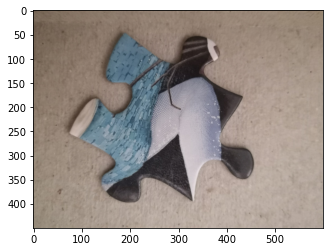

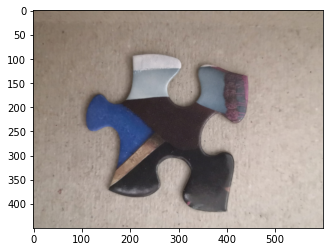

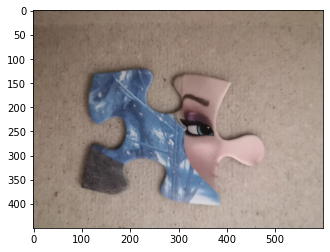

In [4]:
plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()
plt.imshow(image3)
plt.show()


## 1 Additional Filters

[[0.05854983 0.09653235 0.05854983]
 [0.09653235 0.15915494 0.09653235]
 [0.05854983 0.09653235 0.05854983]]


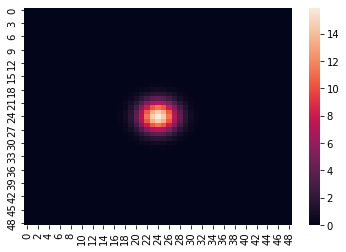

In [5]:
#1
def gauss(sigma, kernel_size,k = 1):
	x, y = np.meshgrid(np.linspace(-1,1,kernel_size), np.linspace(-1,1,kernel_size))
	d = x*x+y*y
	c = (1/ (2* np.pi*(k**2)*sigma**2))
	g = c * np.exp(-( d / ( 2.0 * (k**2) * sigma**2 ) ) )
 
	return g

print(gauss(1,3))
_ = sns.heatmap(gauss(0.1,49))

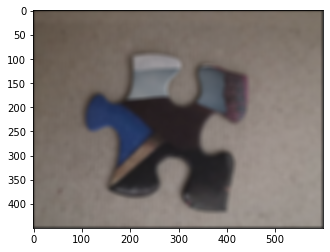

In [6]:
SIGMA = 5
SIZE = 11

img_gauss = np.zeros(image2.shape, dtype=np.float64)

g = gauss(SIGMA,SIZE)

for c in range(3):
    img_gauss[:, :, c] = convolve2d(image2[:, :, c], g, mode = 'same')

plt.imshow(img_gauss)

[[-0.         -0.06389213 -0.09653235 -0.06389213 -0.        ]
 [-0.06389213 -0.18592499 -0.24579405 -0.18592499 -0.06389213]
 [-0.09653235 -0.24579405 -0.31830989 -0.24579405 -0.09653235]
 [-0.06389213 -0.18592499 -0.24579405 -0.18592499 -0.06389213]
 [-0.         -0.06389213 -0.09653235 -0.06389213 -0.        ]]


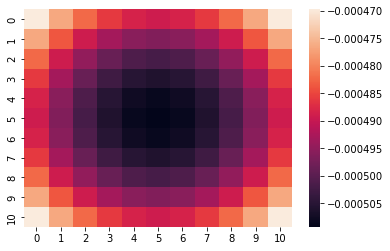

In [10]:
#2
def LoG(sigma, kernel_size):
	x, y = np.meshgrid(np.linspace(-1,1,kernel_size), np.linspace(-1,1,kernel_size))
	d = x*x+y*y
	c = - (1/ (np.pi* sigma**4)) * (1 - d/(2*sigma**2))
 
	g = c * np.exp(-( d / ( 2.0 * sigma**2 ) ) )
 
	return g

print(LoG(1,5))
_ = sns.heatmap(LoG(SIGMA,SIZE))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


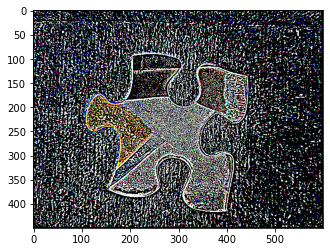

In [11]:
img_log = np.zeros(image2.shape, dtype=np.float64)

g = LoG(0.1,15)

for c in range(3):
    img_log[:, :, c] = convolve2d(image2[:, :, c], g, mode = 'same')


plt.imshow(img_log)

[[0.0131956  0.03989177 0.0131956 ]
 [0.03989177 0.08841941 0.03989177]
 [0.0131956  0.03989177 0.0131956 ]]


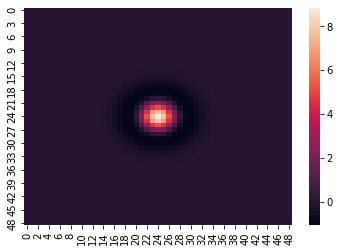

In [9]:
#3
def DoG(sigma,kernal_size,K):
    return gauss(sigma,kernal_size) - gauss(sigma,kernal_size,k=K)

print(DoG(1,3,1.5))
_ = sns.heatmap(DoG(0.1,49,1.5))

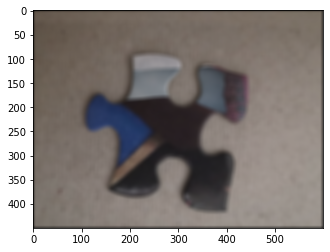

In [10]:
img_dog = np.zeros(image2.shape, dtype=np.float64)

g = DoG(5, 11, 10)

for c in range(3):
    img_dog[:, :, c] = convolve2d(image2[:, :, c], g, mode = 'same')

plt.imshow(img_dog)

## 2 Gaussian Edge and Bar Filters - The RFS/MR8 Filter Banks

In [11]:
#1
def xy_dash(x,y,theta):
    x_dash = x*np.cos(theta)-y*np.sin(theta)
    y_dash = x*np.sin(theta)+y*np.cos(theta)

    return x_dash,y_dash

def f(x,sigma):
    c =1/(np.sqrt(2*np.pi)*sigma)
    f = c* np.exp(-((x**2)/(2*(sigma**2))))
    return f

def df(x,sigma):
    return f(x,sigma)*(-(x/(sigma**2)))

def dfsquared(x,sigma):
    return f(x,sigma)*(((x**2)-(sigma**2))/(sigma**4))

def g_edge(x,y,theta,sigma_x,sigma_y):
    x_new, y_new = xy_dash(x,y,theta)
    a = f(x_new,sigma_x)
    b = df(y_new,sigma_y)
    return a*b

def g_bar(x,y,theta,sigma_x,sigma_y):
    x_new, y_new = xy_dash(x,y,theta)
    a = f(x_new,sigma_x)
    b = dfsquared(y_new,sigma_y)
    return a*b

def gaussian(theta, sigma_x, sigma_y, kernel_size, edge=True):
    x, y = np.meshgrid(np.linspace(-1,1,kernel_size), np.linspace(-1,1,kernel_size))
    if edge:
        return g_edge(x, y, theta, sigma_x, sigma_y)
    else:
        return g_bar(x, y, theta, sigma_x, sigma_y)

In [25]:
#2
def build_RFS():
	RFS = []
	size = 49
	for edge in [True, False]:
		for sigma in [(3, 1), (6, 2), (12,4)]:
			for coef in range(6):

				theta = (coef/6) * np.pi
				RFS.append(gaussian(theta, sigma[0], sigma[1], size, edge))

	RFS.append(gauss(np.sqrt(10), size))
	RFS.append(LoG(np.sqrt(10), size))
	return RFS

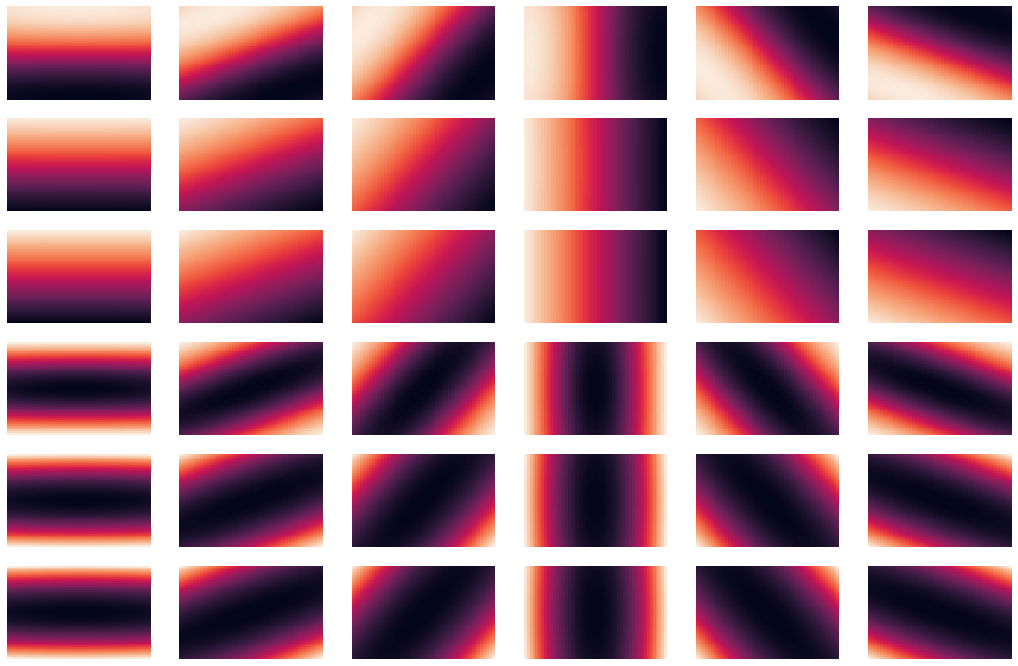

In [27]:
RFS = build_RFS()
fig, ax = plt.subplots(nrows = 6,ncols=6,figsize= (18,12))
row = 0
col = 0
for i in range(36):

	p = sns.heatmap(RFS[i],ax = ax[row][col], yticklabels=False,xticklabels=False, cbar=False)
 
	col += 1
	
	if col == 6:
		row += 1
		col = 0
    
plt.show()

In [73]:
def mr8(image):
    RFS = build_RFS()
    img_final = np.zeros((image.shape[0], image.shape[1], 8))
    plane = 0
    for i in range(0, 36, 6):
        print(f'starting plane {plane}')
        for filter in RFS[i:i+6]:
            act = convolve2d(image, filter, mode='same')
            img_final[:, :, plane] = np.maximum(act, img_final[:, :, plane])

        plane += 1
    img_final[:, :, 6] = convolve2d(image, RFS[36], mode='same')
    img_final[:, :, 7] = convolve2d(image, RFS[37], mode='same')

    return img_final


In [60]:
r_all_mr8 = mr8(image2[:, :, 0])
g_all_mr8 = mr8(image2[:, :, 1])
b_all_mr8 = mr8(image2[:, :, 2])

starting plane 0
starting plane 1
starting plane 2
starting plane 3
starting plane 4
starting plane 5
starting plane 0
starting plane 1
starting plane 2
starting plane 3
starting plane 4
starting plane 5
starting plane 0
starting plane 1
starting plane 2
starting plane 3
starting plane 4
starting plane 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


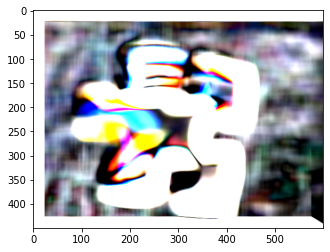

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


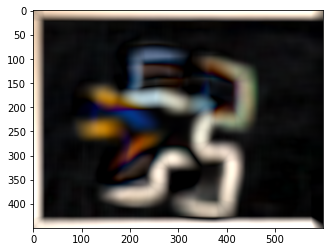

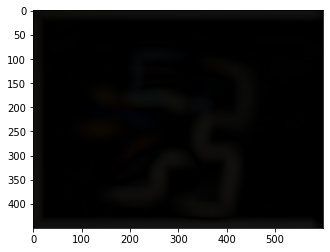

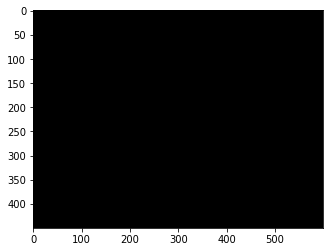

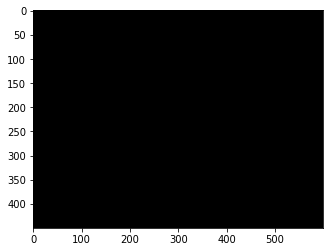

In [73]:
ims = []

for i in range(5):
    plt.imshow(np.swapaxes(np.swapaxes(np.array([r_all_mr8[:, :, i], g_all_mr8[:, :, i], b_all_mr8[:, :, i]]), 0, 1), 1, 2))
    plt.show()

## 3 Local Binary Patterns and Haar Filters

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


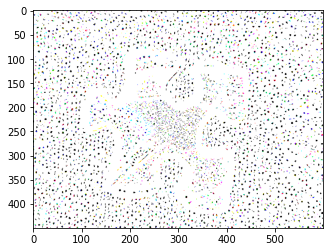

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


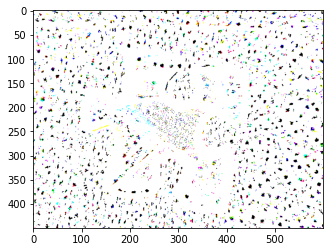

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


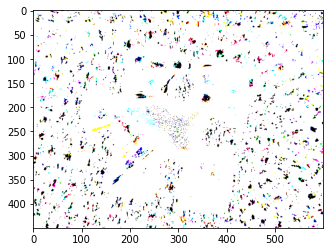

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


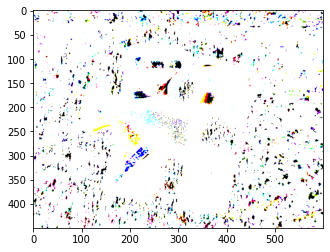

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


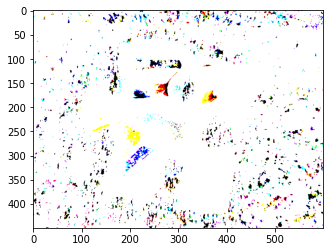

In [18]:
#1

for radius in [4,8,16,24,32]:
	img = np.zeros(image2.shape)
	for channel in [0,1,2]:
		
		img[:,:,channel] = skimage.feature.local_binary_pattern(image2[:,:,channel],12,radius)
	
	plt.imshow(img)
	plt.show()

In [19]:
#1

img_lbp = np.zeros((image2.shape[0], image2.shape[1], 3 * 5))

pos = 0
for radius in [4,8,16,24,32]:
	for channel in [0,1,2]:
		img_lbp[:, :, pos] = skimage.feature.local_binary_pattern(image2[:,:,channel],12,radius)
		pos += 1

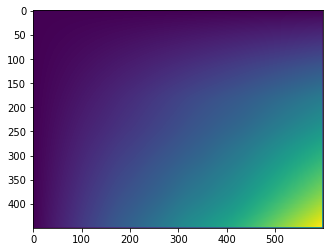

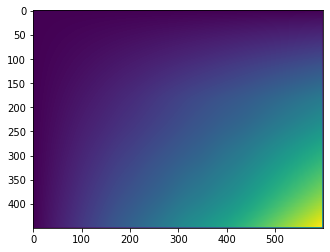

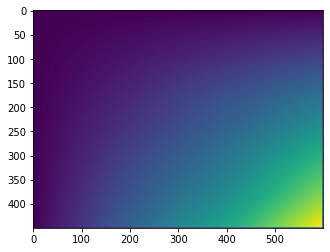

In [20]:
#2
def integral_images(image):
	i_image = np.zeros(image.shape)
	i_image = np.pad(i_image,1)

	for x in range(1,image.shape[0]):
		for y in range(1,image.shape[1]):
			i_image[x,y] = image[x,y] + i_image[x-1,y] + i_image[x,y-1] - i_image[x-1,y-1]

	return i_image[1:-1,1:-1]


img_r = integral_images(image2[:,:,0])
plt.imshow(img_r)
plt.show()

img_g = integral_images(image2[:,:,1])
plt.imshow(img_g)
plt.show()

img_b = integral_images(image2[:,:,2])
plt.imshow(img_b)
plt.show()

In [21]:
#3
def haar_filter(kernel_size):
	filter = np.full((kernel_size,kernel_size),-1)
	
	filter[0:kernel_size//2,0:kernel_size//2] = 1
	filter[kernel_size//2:,kernel_size//2:] = 1

	return filter

In [22]:
haar_img_4 = np.zeros(image2.shape)
filter_4 = haar_filter(4)

haar_img_8 = np.zeros(image2.shape)
filter_8 = haar_filter(8)

haar_img_16 = np.zeros(image2.shape)
filter_16 = haar_filter(16)

for c,i_image in enumerate([img_r,img_g,img_b]):
    
    haar_img_4[:,:,c] = convolve2d(i_image,filter_4,mode = 'same')
    haar_img_8[:,:,c] = convolve2d(i_image,filter_8,mode = 'same')
    haar_img_16[:,:,c] = convolve2d(i_image,filter_16,mode = 'same')

# 4 Textons and Classification

In [23]:
def convolve(img, kernel):
    img_conv = np.zeros(img.shape)
    for i in range(3):
        img_conv[:, :, i] = convolve2d(img[:, :, i], kernel, mode='same') # applying the convolution to each channel seperately
    return img_conv

v_prewitt = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])
h_prewitt = np.array([
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]
])
laplacian = np.array([
    [0, -1, 0],
    [-1, 4, -1],
    [0, -1, 0]
])

#6.2
img_v_prewitt = convolve(image2, v_prewitt)
img_h_prewitt = convolve(image2, h_prewitt)
img_laplacian = convolve(image2, laplacian)

Feature matrix will consist of:

1. Gaussian Filter
2. LoG filter
3. DoG filter
4. Prewitt V
5. Prewitt H
6. Laplacian
7. 38x RFS Bank
8. 8x MR8 Bank
9. 5x LBP
10. 3x Haar
11. RBG
12. HSV

Total = 61 features for each pixel

Total * 3 for RGB 

In [24]:
144 + 18

162

In [25]:
def apply_rfs(image):
    rfs = build_RFS()

    ret = np.zeros((image.shape[0], image.shape[1], 3*len(rfs)))
    pos = 0
    for f in rfs:
        for c in range(3):
            ret[:, :, pos] = convolve2d(image[:, :, c], f, mode='same')
            pos += 1

    return ret

In [28]:
def build_feature(image):
    l = 3 + 3 + 3 + 3 + 3 + 3 + 114 + 8*3 + 15 + 9 + 3 + 3
    a = np.prod(image.shape[:-1])
    feature = np.zeros((a, l))

    # Gaussian filters
    feature[:, :3] = img_gauss.reshape(a, 3)
    feature[:, 3:6] = img_log.reshape(a, 3)
    feature[:, 6:9] = img_dog.reshape(a, 3)

    # Edge filters
    feature[:, 9:12] = img_v_prewitt.reshape(a, 3)
    feature[:, 12:15] = img_h_prewitt.reshape(a, 3)
    feature[:, 15:18] = img_laplacian.reshape(a, 3)

    # RFS
    feature[:, 18:132] = apply_rfs(image).reshape(a, 114)

    # MR8
    feature[:, 132:140] = mr8(image[:, :, 0]).reshape(a, 8)
    feature[:, 140:148] = mr8(image[:, :, 1]).reshape(a, 8)
    feature[:, 148:156] = mr8(image[:, :, 2]).reshape(a, 8)

    # LBP
    feature[:, 156:171] = img_lbp.reshape(a, 15)

    # Haar
    feature[:, 171:174] = haar_img_4.reshape(a, 3)
    feature[:, 174:177] = haar_img_8.reshape(a, 3)
    feature[:, 177:180] = haar_img_16.reshape(a, 3)

    # RGB
    feature[:, 180:183] = image.reshape(a, 3)

    # HSV
    feature[:, 183:186] = cv2.cvtColor(image.astype(np.float32), cv2.COLOR_RGB2HSV).reshape(a, 3)

    return feature
    

feat = build_feature(image2)

starting plane 0
starting plane 1
starting plane 2
starting plane 3
starting plane 4
starting plane 5
starting plane 0
starting plane 1
starting plane 2
starting plane 3
starting plane 4
starting plane 5
starting plane 0
starting plane 1
starting plane 2
starting plane 3
starting plane 4
starting plane 5


In [29]:
def feat_no_banks(image):
    l = 48
    a = np.prod(image.shape[:-1])
    feature = np.zeros((a, l))

    # Gaussian filters
    feature[:, :3] = img_gauss.reshape(a, 3)
    feature[:, 3:6] = img_log.reshape(a, 3)
    feature[:, 6:9] = img_dog.reshape(a, 3)

    # Edge filters
    feature[:, 9:12] = img_v_prewitt.reshape(a, 3)
    feature[:, 12:15] = img_h_prewitt.reshape(a, 3)
    feature[:, 15:18] = img_laplacian.reshape(a, 3)

    feature[:, 18:33] = img_lbp.reshape(a, 15)

    # Haar
    feature[:, 33:36] = haar_img_4.reshape(a, 3)
    feature[:, 36:39] = haar_img_8.reshape(a, 3)
    feature[:, 39:42] = haar_img_16.reshape(a, 3)

    # RGB
    feature[:, 42:45] = image.reshape(a, 3)

    # HSV
    feature[:, 45:48] = cv2.cvtColor(image.astype(np.float32), cv2.COLOR_RGB2HSV).reshape(a, 3)

    return feature

feat2 = feat_no_banks(image2)

In [30]:
km = KMeans(n_clusters=4).fit(feat)

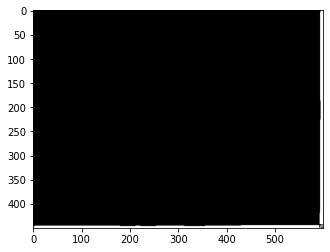

In [31]:
plt.imshow(km.labels_.reshape((450, 600)), cmap='gray')

In [32]:
feat = np.hstack((feat, km.labels_.reshape((270000,1))))
feat.shape

(270000, 187)

In [33]:
m = feat.mean(axis=0)
c = np.cov(feat.T)

In [34]:
mvn = multivariate_normal(mean = m, cov = c, allow_singular=True)

60.02777777777778% accuracy


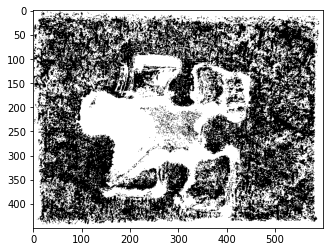

In [35]:
def get_mask(pdf, thresh):
    t = pdf < thresh
    t = t.astype(int)
    return t

def get_acc(our_mask, true_mask):
    a = 0
    for o, t in zip(our_mask.flatten(), true_mask.flatten()):
        a += np.abs(o - t)

    a /= our_mask.shape[0] * our_mask.shape[1]
    return 1-a

mask2 = cv2.imread('../images/mask-83.png', cv2.IMREAD_GRAYSCALE)

thresh = threshold_mean(mask2)

mask2_bin = (mask2 > thresh).astype(int)

pdf = mvn.pdf(feat).reshape(450, 600)

theta = np.max(pdf)*1/11000

a = get_acc(get_mask(pdf, theta), mask2_bin)

print(f'{a * 100}% accuracy')
plt.imshow(get_mask(pdf, theta), cmap='gray')
plt.show()

In [37]:
image2_hsv = cv2.cvtColor(image2.astype(np.float32), cv2.COLOR_RGB2HSV)

feat = np.hstack((feat, mr8(image2_hsv[:, :, 0]).reshape((270000, 8))))
feat = np.hstack((feat, mr8(image2_hsv[:, :, 1]).reshape((270000, 8))))
feat = np.hstack((feat, mr8(image2_hsv[:, :, 2]).reshape((270000, 8))))


starting plane 0
starting plane 1
starting plane 2
starting plane 3
starting plane 4
starting plane 5
starting plane 0
starting plane 1
starting plane 2
starting plane 3
starting plane 4
starting plane 5
starting plane 0
starting plane 1
starting plane 2
starting plane 3
starting plane 4
starting plane 5


52.867407407407406% accuracy


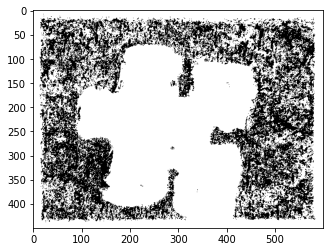

In [39]:
m = feat.mean(axis=0)
c = np.cov(feat.T)

mvn = multivariate_normal(mean = m, cov = c, allow_singular=True)

pdf = mvn.pdf(feat).reshape(450, 600)

theta = np.max(pdf)*1/1000

a = get_acc(get_mask(pdf, theta), mask2_bin)

print(f'{a * 100}% accuracy')
plt.imshow(get_mask(pdf, theta), cmap='gray')
plt.show()